# Intersection

In this notebook we demonstrate how to define a T-shape intersection with AutomotiveDrivingModels.  You will also learn how to define your own custom action type and driver model type.


In [15]:
using AutomotiveDrivingModels

# All the functions related to visualization
using AutoViz
using Random # for RNGs

## Generate a T-Shape intersection

In order to generate the road network, one first initializes a Roadway object.

In [16]:
roadway = Roadway();

In [17]:
# Define coordinates of the entry and exit points to the intersection
r = 5.0 # turn radius
A = VecSE2(0.0,DEFAULT_LANE_WIDTH,-π)
B = VecSE2(0.0,0.0,0.0)
C = VecSE2(r,-r,-π/2)
D = VecSE2(r+DEFAULT_LANE_WIDTH,-r,π/2)
E = VecSE2(2r+DEFAULT_LANE_WIDTH,0,0)
F = VecSE2(2r+DEFAULT_LANE_WIDTH,DEFAULT_LANE_WIDTH,-π)

3-element VecSE2{Float64} with indices SOneTo(3):
 13.0              
  3.0              
 -3.141592653589793

The next step consists in appending all the lanes to the road network. We can define a helper function to add a new lane to the roadway.

In [18]:
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

append_to_curve! (generic function with 1 method)

Example of a lane that consists in 3 road segments, a straight curve (from the left to the center), a turning part (right turn) and a final straight curve. You can visualize the lane that has been added to the roadway

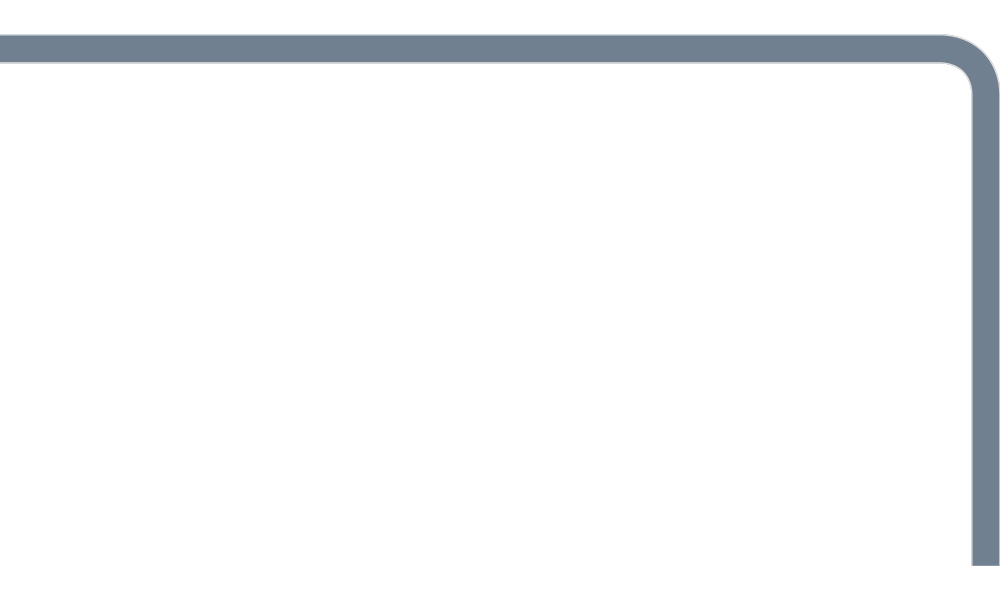

In [19]:
# Append right turn coming from the left
curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_bezier_curve(B, C, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50.0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))

#visualize first lane
cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

Let's repeat the process and complete the T-shape intersection

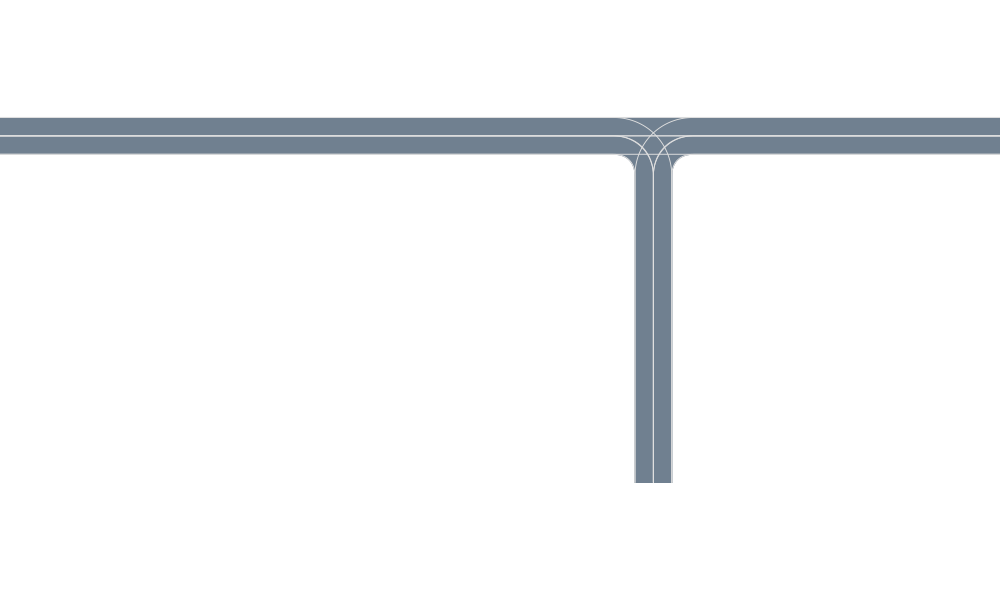

In [20]:
# Append straight left
curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, B), convert(VecE2, E), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))

# Append straight right
curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, F), convert(VecE2, A), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))

# Append left turn coming from the right
curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_bezier_curve(F, C, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))

# Append right turn coming from below
curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, E, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))

# Append left turn coming from below
curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, A, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))

cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

We can identify each lane thanks to the following user-defined functions. We define a ```LaneOverlay``` object that indicate the lane to highlight. One could implement any custom type to display other information on the lane. We then add a new method to the  ```render!``` function that execute the specific action (coloring in blue). Look at Autoviz.jl for more detail on the ```render!``` function.

Use the slider to highlight each lane. The number corresponds to a road segment.

**Note :** In order to render the intersection, one must first initialize a ```Scene``` object.

In [21]:
using Interact

scene = Scene()

struct LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

@manipulate for i in 1 : length(roadway.segments)
    render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 6,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
3, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Maxime\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Maxime\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Maxime\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Maxime\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Maxime\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013118e70, Task (runnable) @0x0000000013118e70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"13981007195005142646\",\"id\":\"ob_18\",\"type\":\"observable\"}),\"index\":WebIO.getval(

## Navigate in the new road network

Let's populate the intersection

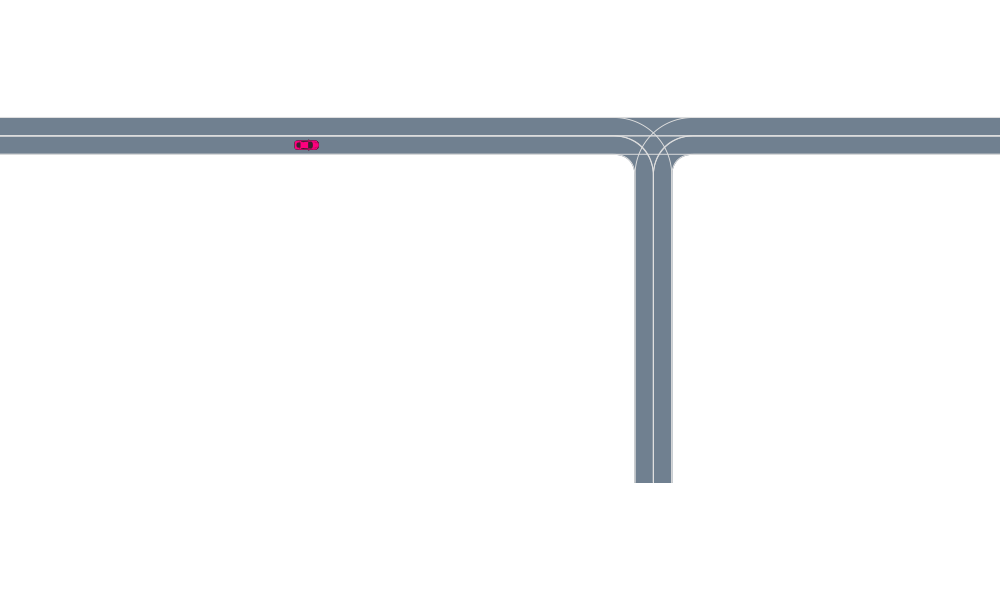

In [22]:
scene = Scene()
vs0 = VehicleState(B + polar(50.0,-π), roadway, 8.0) # initial state of the vehicle
push!(scene, Vehicle(vs0, VehicleDef(), 1)) # add vehicle with the default type

render(scene, roadway, cam=cam)

We will use lateral and longitudinal acceleration to control a car in the intersection. The first step is to define a corresponding action type that will contain the acceleration inputs.


In [23]:
struct LaneSpecificAccelLatLon
    a_lat::Float64
    a_lon::Float64
end

Next, add a method to the propagate function to update the state using our new action type. 


**Note:** There is an existing propagate method to update the state using lateral and longitudinal acceleration. (it is used in line 3)

In [24]:
function AutomotiveDrivingModels.propagate(veh::Vehicle, action::LaneSpecificAccelLatLon, roadway::Roadway, Δt::Float64)
    lane_tag_orig = veh.state.posF.roadind.tag
    state = propagate(veh, LatLonAccel(action.a_lat, action.a_lon), roadway, Δt)
    roadproj = proj(state.posG, roadway[lane_tag_orig], roadway, move_along_curves=false)
    retval = VehicleState(Frenet(roadproj, roadway), roadway, state.v)
    return retval
end

**Driver Model:**

We define a driver model, which can be seen as a distribution over actions. Here we will define the simplest model, which is to repeat the same action.

In [25]:
struct InterDriver <: DriverModel{LaneSpecificAccelLatLon}
    a::LaneSpecificAccelLatLon
end
AutomotiveDrivingModels.get_name(model::InterDriver) = "InterDriver"
AutomotiveDrivingModels.observe!(model::InterDriver, scene::Scene, roadway::Roadway, egoid::Int64) = model
Base.rand(::AbstractRNG, model::InterDriver) = model.a

**Simulate: **

First associate a model to each driver in the scene using a dictionnary. Here we only have one driver identified by its ID: 1. Then everything is ready to run the ```simulate!``` function.

In [26]:
timestep = 0.1

models = Dict{Int, DriverModel}()
# constant speed model
models[1] = InterDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
scenes = simulate!(scene, roadway, models, nticks, timestep)

# interactive visualization
@manipulate for frame_index in 1 : length(scenes)
    render(scenes[frame_index], roadway, cam=cam)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame_index"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 101,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Maxime\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Maxime\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Maxime\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Maxime\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Maxime\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000002c242290, Task (runnable) @0x000000002c242290), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\"